In [1]:
%pylab tk

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.integrate import odeint

In [3]:
species = 5
cdp_i, cd_i, p_i, cdc_i, c_i = range(0,species)

def f(y, t, plate_flow, Ka1, k1on, Ka3, k3on, gradient):
    ar_y = y.reshape(-1, species)
    out = zeros(ar_y.shape)
    k1off = k1on / Ka1
    k3off = k3on / Ka3

    cdp=ar_y[:,cdp_i]
    cd=ar_y[:,cd_i]
    p = ar_y[:,p_i]
    cdc = ar_y[:,cdc_i]
    c = ar_y[:,c_i]    
    
    #operations between columns
    out[:,cdp_i]= k1on*p*cd - k1off*cdp
    out[:,cdc_i] = k3on*c*cd - k3off*cdc
    out[:,c_i] = -(k3on*c*cd - k3off*cdc)
    out[:,p_i] = -(k1on*p*cd - k1off*cdp)
    out[:,cd_i]= -(k1on*p*cd - k1off*cdp) - (k3on*c*cd - k3off*cdc)   
    
    #operations between plates (rows)
    additional = hstack((0, ar_y[:,p_i]))
    out[:,p_i] = out[:,p_i] - plate_flow*ar_y[:,p_i] + plate_flow*additional[0:-1]
    additional = hstack((0, ar_y[:,c_i]))
    out[:,c_i] = out[:,c_i] - plate_flow*ar_y[:,c_i] + plate_flow*additional[0:-1]
    
    for grad in gradient:
        (a, b, conc) = grad
        out[0, c_i] = out[0, c_i] + plate_flow*conc*((0.5*(t-a)+0.5*abs(t-a))-(0.5*(t-(a+b))+0.5*abs(t-(a+b))))/(b)
    
    return out.reshape(-1,1)[:,0]

def run_ode(plates, species, protein_concentration, times, plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=1.0):
    col = zeros((plates, species))
    col[:, cd_i] = protein_concentration # concentration of active group on the resin
    col[:, p_i] = protein_concentration*coumarin_factor#analyte
    linear_col = col.reshape(-1,1)
    result = odeint(f, linear_col[:,0], times, args=(plate_flow, k1, k1*kinetic_factor, k2, k2*kinetic_factor, gradient),\
                   printmessg=False, rtol=10**-13, atol=10**-13)
    return result

#Test section

In [4]:
#global parameters that we want to keep constant for all simulations
col_vol = 0.1
flow = 0.01 #ml/min
flow = flow/60.0 #ml/s
plates = 10
plate_vol = col_vol / plates
plate_flow = flow/plate_vol

volumes = arange(0, 0.5, 0.001)
times = volumes / flow
cvs = volumes / col_vol

kinetic_factor = 1000.0

In [5]:
protein_concentration = ((100*10**-6)*(40*10**-6)/(col_vol)) * 10**3

grad_start, grad_volume = 0.1, 0.5
gradient = []
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
k1=1.0/(20*10.0**-9.0)
k2=10**6#1.0/(0.5*10.0**-9.0)

#actual simulation code
result = run_ode(plates, species, protein_concentration, times, \
                 plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=1.0)

In [6]:
figure(1, figsize=(10, 8))
clf()

plot(volumes, result[:,p_i-species], label='Coumarin-estradiol')
#plot(cvs, result[:,c_i-species])
#plot(cvs, result[:,cdp_i-species])
#plot(volumes, result[:,cdc_i-species], label='cdc')
#plot(volumes, result[:,cd_i-species], label='cd')
#plot(volumes, result[:,cdp_i-species], label='cdp')
grid()
legend()
ylim((-0.000001, 0.00004))
xlabel('Volume / ml')
ylabel('Concentration')

savefig('example2.pdf')

C:\Users\rkwant\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\backends\backend_pdf.py:1100: UserWarning: 'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


#Leakage problem

In [383]:
grad_start, grad_volume = 0.1, 0.1
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
k1=1.0/(20.0*10.0**-9.0)
k2=1.0/(0.5*10.0**-9.0)

elution_results = []
nonelution_results = []

cfactor = 1.0

ppow = arange(-6, -3, 0.5)#power of concentration, in molar
protein_concentrations = [((100*10**-6)*(10**k)/(col_vol)) * 10**3 for k in ppow]
for protein_concentration in protein_concentrations:
    result_elution = run_ode(plates, species, protein_concentration, times, \
                             plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=cfactor)
    result_noelution = run_ode(plates, species, protein_concentration, times, \
                               plate_flow, k1, k2, kinetic_factor, [], coumarin_factor=cfactor)
    
    elution_results.append(result_elution[:,p_i-species] / protein_concentration)
    nonelution_results.append(result_noelution[:,p_i-species] / protein_concentration)

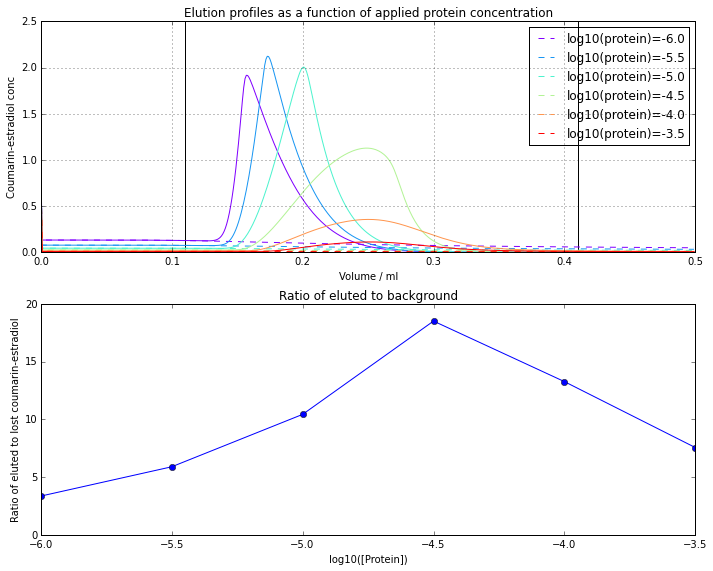

In [384]:
figure(1, figsize=(10, 8))
clf()

intstart, intstep = 0.11, 0.3
sel1 = where((volumes>intstart)&(volumes<intstart+intstep))
colors = cm.rainbow(linspace(0, 1, len(elution_results)))
ratio_results = []

subplot(211)
for i,(e, noe) in enumerate(zip(elution_results, nonelution_results)):
    plot(volumes, noe, '--', color=colors[i], label='log10(protein)=%0.1f'%(log10(protein_concentrations[i])))
    plot(volumes, e, color=colors[i])
    
    ratio_results.append((e[sel1].sum(), \
                    noe[sel1].sum()))
ratio_results = array(ratio_results)

legend()
grid()
xlabel('Volume / ml')
ylabel('Coumarin-estradiol conc')
title('Elution profiles as a function of applied protein concentration')
vlines([intstart, intstart+intstep], 0, ylim()[1])

subplot(212)
plot(ppow, ratio_results[:,0] / ratio_results[:,1], 'o-')
title('Ratio of eluted to background')
xlabel('log10([Protein])')
ylabel('Ratio of eluted to lost coumarin-estradiol')
legend()
ylim(ymin=0)


tight_layout()

#savefig('leakage_cfactor_%0.2f-%0.1f-%0.1f.pdf'%(cfactor, intstart, intstep))

#Ratio of signal turn on

In [393]:
grad_start, grad_volume = 0.1, 0.1
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
k1=1.0/(20.0*10.0**-9.0)
k2=1.0/(0.5*10.0**-9.0)
protein_concentration = ((100*10**-6)*(40*10**-6)/(col_vol)) * 10**3

cfactor = 0.9

k2pow = arange(5, 10, 0.5)
k2list = [10**k for k in k2pow]

spectra = []
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
for i,k2 in enumerate(k2list):
    result = run_ode(plates, species, protein_concentration, times, \
                     plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=cfactor)
    spectra.append(result[:, p_i-species])
        
buffer_spectrum = run_ode(plates, species, protein_concentration, times, \
                          plate_flow, k1, k2, kinetic_factor, [], coumarin_factor=cfactor)

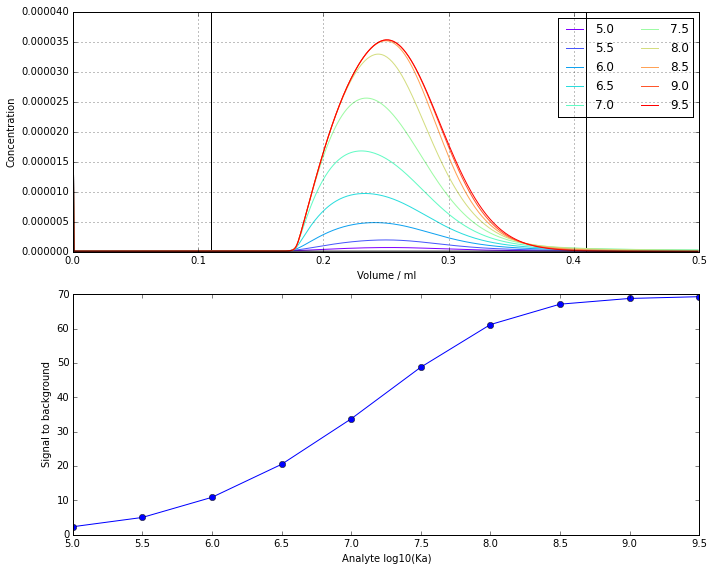

In [394]:
figure(1, figsize(10, 8))

intstart, intstep = 0.11, 0.3
sel = where((volumes>intstart)&(volumes<intstart+intstep))
analyte_results = []

subplot(211)
colors = cm.rainbow(linspace(0, 1, len(spectra)))
for i,result in enumerate(spectra):
    plot(volumes, result, color=colors[i], label=k2pow[i])
    analyte_results.append(result[sel].sum() / buffer_spectrum[:, p_i-species][sel].sum())
    
legend(ncol=2)
plot(volumes, buffer_spectrum[:, p_i-species], color='black')
grid()

vlines([intstart, intstart+intstep], 0, ylim()[1])
xlabel('Volume / ml')
ylabel('Concentration')


subplot(212)
plot(k2pow, analyte_results, 'o-')
ylabel('Signal to background')
xlabel('Analyte log10(Ka)')

tight_layout()
savefig('signal_vs_ka_cfactor%0.2f.pdf'%(cfactor))

#limit of concentration detection

In [459]:
grad_start, grad_volume = 0.1, 0.1
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
k1=1.0/(20.0*10.0**-9.0)
k2=1.0/(0.5*10.0**-9.0)
protein_concentration = ((100*10**-6)*(40*10**-6)/(col_vol)) * 10**3

cfactor = 0.1
anpow = linspace(-7, -3.5, 15)
anconc = 10**anpow

spectra = []

for analyte_conc in anconc:
    gradient = [(grad_start / flow, 1, analyte_conc), ((grad_start+grad_volume) / flow, 1, -analyte_conc)]
    result = run_ode(plates, species, protein_concentration, times, \
                     plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=cfactor)
    spectra.append(result[:, p_i-species])
        
buffer_spectrum = run_ode(plates, species, protein_concentration, times, \
                          plate_flow, k1, k2, kinetic_factor, [], coumarin_factor=cfactor)

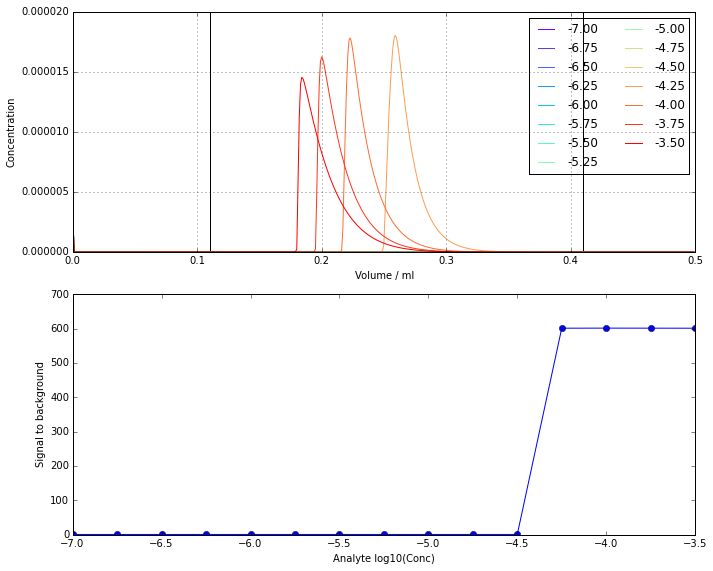

In [460]:
figure(1, figsize(10, 8))

intstart, intstep = 0.11, 0.3
sel = where((volumes>intstart)&(volumes<intstart+intstep))
analyte_results = []

subplot(211)
colors = cm.rainbow(linspace(0, 1, len(spectra)))
for i,result in enumerate(spectra):
    plot(volumes, result, color=colors[i], label='%0.2f'%(anpow[i]))
    analyte_results.append(result[sel].sum() / buffer_spectrum[:, p_i-species][sel].sum())
    
legend(ncol=2)
plot(volumes, buffer_spectrum[:, p_i-species], color='black')
grid()

vlines([intstart, intstart+intstep], 0, ylim()[1])
xlabel('Volume / ml')
ylabel('Concentration')


subplot(212)
plot(anpow, analyte_results, 'o-')
ylabel('Signal to background')
xlabel('Analyte log10(Conc)')

tight_layout()
savefig('conc_sensitivity_c0.1.pdf')

#graph of cfactors

In [410]:
grad_start, grad_volume = 0.1, 0.1
gradient = [(grad_start / flow, 1, 40*10**-6), ((grad_start+grad_volume) / flow, 1, -40*10**-6)]
k1=1.0/(20.0*10.0**-9.0)
k2=1.0/(0.5*10.0**-9.0)
protein_concentration = ((100*10**-6)*(40*10**-6)/(col_vol)) * 10**3

analyte_spectra = []
buffer_spectra = []
clist = [10**c for c in linspace(-2, 0, num=20)]
for cfactor in clist:
    result = run_ode(plates, species, protein_concentration, times, \
                     plate_flow, k1, k2, kinetic_factor, gradient, coumarin_factor=cfactor)
    analyte_spectra.append(result[:, p_i-species])
    
    buffer_spectrum = run_ode(plates, species, protein_concentration, times, \
                          plate_flow, k1, k2, kinetic_factor, [], coumarin_factor=cfactor)
    buffer_spectra.append(buffer_spectrum[:, p_i-species])

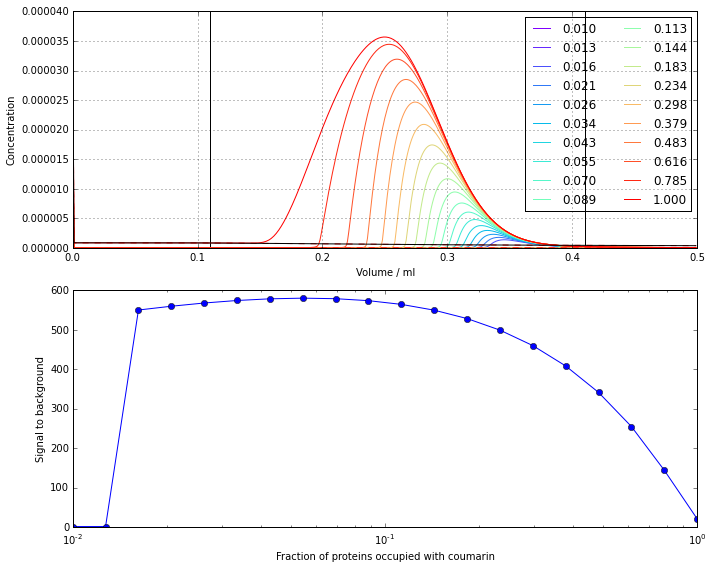

In [412]:
figure(1, figsize(10, 8))

intstart, intstep = 0.11, 0.3
sel = where((volumes>intstart)&(volumes<intstart+intstep))
analyte_results = []

subplot(211)
colors = cm.rainbow(linspace(0, 1, len(analyte_spectra)))
for i,(an, buff) in enumerate(zip(analyte_spectra, buffer_spectra)):
    plot(volumes, an, color=colors[i], label="%0.3f"%(clist[i]))
    plot(volumes, buff, '--', color=colors[i])
    analyte_results.append(an[sel].sum() / buff[sel].sum())
    
legend(ncol=2)
plot(volumes, buffer_spectrum[:, p_i-species], color='black')
grid()

vlines([intstart, intstart+intstep], 0, ylim()[1])
xlabel('Volume / ml')
ylabel('Concentration')


subplot(212)
semilogx(clist, analyte_results, 'o-')

ylabel('Signal to background')
xlabel('Fraction of proteins occupied with coumarin')

tight_layout()
savefig('cval_plot.pdf')